# Turing Patterns

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from train_dynamics import FlowModel
from train_dynamics import load_score_model
from turing_pattern import GrayScottSimulator, create_random_state, TuringPatternDataset
from tqdm import tqdm

from training_free import training_free_flow, sde_solve
from visulization import TuringPlotter, plot_trace

# Set matplotlib to use STIX fonts for better LaTeX compatibility
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 10

In [2]:
def ground_truth_simulation(name, x0, T=500, dt=1.0):
    sim = GrayScottSimulator(pattern_preset=name, device='cuda', dt=dt)
    u, v = x0[0].unsqueeze(0), x0[1].unsqueeze(0)
    u, v = sim.forward(u, v, steps=1000, trace=True)
    trace_true = torch.cat([u, v], dim=0).permute(1,0,2,3).unsqueeze(1)
    return trace_true

In [114]:
# set random seed for reproducibility
torch.manual_seed(1)

sim_results = {}
gs_results = {}
for name in ['life', 'waves', 'spirals', 'maze']:
    for gamma in [-1, 1]:
        k = torch.Tensor([[0, gamma], [-gamma, 0]]).reshape(2,2,1,1)
        k = k / k.norm()
        
        f, score, dataset, scheduler = training_free_flow(name, t=10, k=k)
        x0 = dataset[0].cuda().unsqueeze(0)
        x0_diffused = scheduler.add_noise(x0, torch.randn_like(x0), torch.LongTensor([10]))
        trace, trace_pred = sde_solve(f, score, scheduler, x0_diffused, 300, dt=0.01, eta=0.1, v_factor=1)
        sim_results[gamma, name] = dataset.denormalize(trace_pred)
    gs_results[name] = ground_truth_simulation(name, dataset.denormalize(x0)[0])

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:08<00:00, 37.19it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:08<00:00, 36.27it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 44.36it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 43.96it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 44.98it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 49.19it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 49.56it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.84it/s]


In [104]:
def ema(traj, t, eta=0.00):
    ema_pattern = traj[0]
    for i in range(t):
        ema_pattern = eta * ema_pattern + (1 - eta) * traj[i]
    return ema_pattern

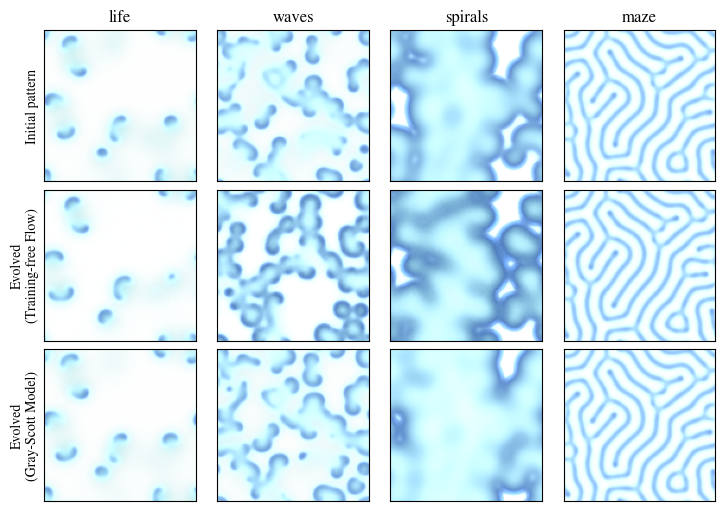

In [126]:
models = [
    (1, 'life'), 
    (1, 'waves'), 
    (-1, 'spirals'), 
    (1, 'maze')
]

fig = plt.figure(figsize=(7.2, 5), constrained_layout=True)
axs = fig.subplots(3, len(models), sharex=True, sharey=True)
plotter = TuringPlotter()

for i, (gamma, name) in enumerate(models):
    # 1. original
    plotter.plot(gs_results[name][0], name, ax=axs[0, i])
    axs[0, i].set_title(name)
    axs[0, i].set_xticks([]); axs[0, i].set_yticks([])
    if i == 0:
        axs[0, i].set_ylabel('Initial pattern')

    # 2. recovered
    plotter.plot(ema(sim_results[gamma, name], 250, 0.9), name, ax=axs[1, i])
    if i == 0:
        axs[1, i].set_ylabel('Evolved\n(Training-free Flow)')

    # 3. ground-truth
    plotter.plot(gs_results[name][50], name, ax=axs[2, i])
    if i == 0:
        axs[2, i].set_ylabel('Evolved\n(Gray-Scott Model)')

plt.savefig('./figures/simulations.pdf', bbox_inches='tight')
plt.show()

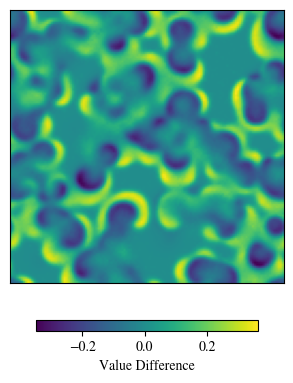

In [41]:
name = 'waves'
ema_pattern = sim_results[name][0]
eta = 0.95
for i in range(200):
    ema_pattern = eta * ema_pattern + (1 - eta) * sim_results[name][i]

plt.figure(figsize=(4, 4))
diff = ema_pattern - sim_results[name][0]

im = plt.imshow(diff[0, 1].cpu().numpy())
plt.colorbar(im, shrink=0.6, label='Value Difference', orientation='horizontal', pad=0.1)
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.savefig('../cover/waves_ema.pdf', bbox_inches='tight')
plt.show()

# Mismatching Test

In [32]:
# set random seed for reproducibility
torch.manual_seed(1)

score_names = ['life', 'waves', 'spirals', 'maze']
flow_names = ['maze', 'life', 'waves', 'spirals']

sim_results_mismatch = {}
gs_results_mismatch = {}
for name, name_f in zip(score_names, flow_names):
    _, score, dataset, scheduler = training_free_flow(name)
    f, _, _, _ = training_free_flow(name_f)
    x0 = dataset[0].cuda().unsqueeze(0)
    trace, trace_pred = sde_solve(f, score, scheduler, x0, 300, dt=0.01, eta=0.1, v_factor=1)
    sim_results_mismatch[name] = dataset.denormalize(trace_pred)
    gs_results_mismatch[name] = ground_truth_simulation(name, dataset.denormalize(x0)[0])

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128
Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 37.87it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128
Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.66it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128
Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 42.10it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128
Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.67it/s]


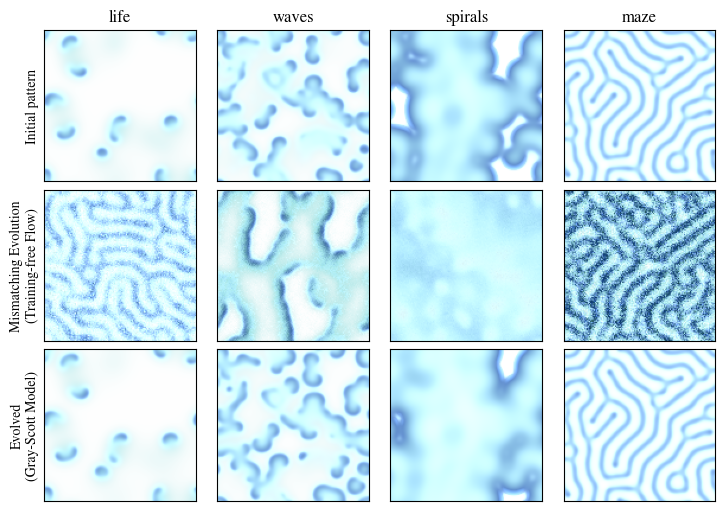

In [35]:
models = ['life', 'waves', 'spirals', 'maze']

fig = plt.figure(figsize=(7.2, 5), constrained_layout=True)
axs = fig.subplots(3, len(models), sharex=True, sharey=True)
plotter = TuringPlotter()

for i, name in enumerate(models):
    # 1. original
    plotter.plot(gs_results_mismatch[name][0], name, ax=axs[0, i])
    axs[0, i].set_title(name)
    axs[0, i].set_xticks([]); axs[0, i].set_yticks([])
    if i == 0:
        axs[0, i].set_ylabel('Initial pattern')

    # 2. recovered
    plotter.plot(sim_results_mismatch[name][200], name, ax=axs[1, i])
    if i == 0:
        axs[1, i].set_ylabel('Mismatching Evolution\n(Training-free Flow)')

    # 3. ground-truth
    plotter.plot(gs_results_mismatch[name][50], name, ax=axs[2, i])
    if i == 0:
        axs[2, i].set_ylabel('Evolved\n(Gray-Scott Model)')

plt.savefig('./figures/simulations_mismatch.pdf', bbox_inches='tight')
plt.show()

# Cover Plot

In [5]:
f, score, dataset, scheduler = training_free_flow('waves')

Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


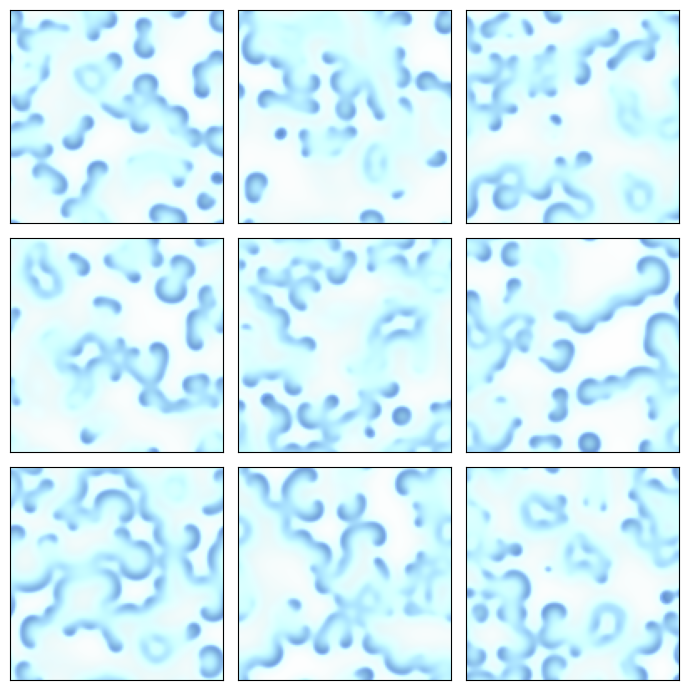

In [18]:
plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plotter.plot(dataset.denormalize(dataset[i].unsqueeze(0)), 'waves')
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.savefig('../cover/waves_snapshots.pdf', bbox_inches='tight')
plt.show()

# Uniqueness of Dynamics

### Compare learned with ground truth

In [80]:
# set random seed for reproducibility
torch.manual_seed(1)

sim_results = {}
gs_results = {}
for gamma in [-1, 1]:
    # check all possible kernels
    k = torch.Tensor([[0, gamma], [-gamma, 0]]).reshape(2,2,1,1)
    k = k / k.norm()
    for name_main in ['life', 'waves', 'spirals', 'maze']:
        f_main, score_main, dataset_main, scheduler_main = training_free_flow(name_main, k=k)
        x0 = dataset_main[0].cuda().unsqueeze(0)
        trace, trace_pred = sde_solve(f_main, score_main, scheduler_main, x0, 50, dt=0.01, eta=0.1, v_factor=1)
        sim_results[gamma, name_main] = dataset_main.denormalize(trace)
        # sim_results[gamma, name_main] = ground_truth_simulation(name_main, dataset_main.denormalize(x0)[0])

        for name_compare in ['life', 'waves', 'spirals', 'maze']:
            print(f'[GrayScottSimulator]: {name_main} [main] vs {name_compare} [compare]')
            gs_results[gamma, name_main, name_compare] = ground_truth_simulation(name_compare, dataset_main.denormalize(x0)[0])

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 36.21it/s]


[GrayScottSimulator]: life [main] vs life [compare]
[GrayScottSimulator]: life [main] vs waves [compare]
[GrayScottSimulator]: life [main] vs spirals [compare]
[GrayScottSimulator]: life [main] vs maze [compare]
Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 37.87it/s]


[GrayScottSimulator]: waves [main] vs life [compare]
[GrayScottSimulator]: waves [main] vs waves [compare]
[GrayScottSimulator]: waves [main] vs spirals [compare]
[GrayScottSimulator]: waves [main] vs maze [compare]
Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 44.31it/s]


[GrayScottSimulator]: spirals [main] vs life [compare]
[GrayScottSimulator]: spirals [main] vs waves [compare]
[GrayScottSimulator]: spirals [main] vs spirals [compare]
[GrayScottSimulator]: spirals [main] vs maze [compare]
Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 39.82it/s]


[GrayScottSimulator]: maze [main] vs life [compare]
[GrayScottSimulator]: maze [main] vs waves [compare]
[GrayScottSimulator]: maze [main] vs spirals [compare]
[GrayScottSimulator]: maze [main] vs maze [compare]
Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 37.39it/s]


[GrayScottSimulator]: life [main] vs life [compare]
[GrayScottSimulator]: life [main] vs waves [compare]
[GrayScottSimulator]: life [main] vs spirals [compare]
[GrayScottSimulator]: life [main] vs maze [compare]
Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 38.32it/s]


[GrayScottSimulator]: waves [main] vs life [compare]
[GrayScottSimulator]: waves [main] vs waves [compare]
[GrayScottSimulator]: waves [main] vs spirals [compare]
[GrayScottSimulator]: waves [main] vs maze [compare]
Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 44.34it/s]


[GrayScottSimulator]: spirals [main] vs life [compare]
[GrayScottSimulator]: spirals [main] vs waves [compare]
[GrayScottSimulator]: spirals [main] vs spirals [compare]
[GrayScottSimulator]: spirals [main] vs maze [compare]
Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 50/50 [00:01<00:00, 45.82it/s]


[GrayScottSimulator]: maze [main] vs life [compare]
[GrayScottSimulator]: maze [main] vs waves [compare]
[GrayScottSimulator]: maze [main] vs spirals [compare]
[GrayScottSimulator]: maze [main] vs maze [compare]


In [43]:
def synamics_representation(traj, t, eta=0.00):
    start = traj[0]
    if eta > 0:
        ema_pattern = start
        for i in range(t):
            ema_pattern = eta * ema_pattern + (1 - eta) * traj[i]
        end = ema_pattern
    else:
        end = traj[t]

    rep = (end - start).reshape(-1)
    rep = rep / rep.norm()
    return rep

In [91]:
# make table
GS_T = 1
SIM_T = 20#250
TEA = 0.

sim_table = {}
for main_name in ["life", "waves", "spirals", "maze"]:
    for compare_name in ["life", "waves", "spirals", "maze"]:
        sims = []
        for gamma in [-1, 1]:
            sim = synamics_representation(
                sim_results[gamma, main_name].cpu(), SIM_T, TEA
            ) @ synamics_representation(gs_results[gamma, main_name, compare_name].cpu(), GS_T, TEA)
            sims.append(sim.abs().item())
        sim_table[main_name, compare_name] = sims

In [92]:
# plot table in markdown with pandas
import pandas as pd

# Convert nested dictionary to proper DataFrame format
data = {}
for (main_name, compare_name), value in sim_table.items():
    if main_name not in data:
        data[main_name] = {}
    data[main_name][compare_name] = max(value)

df = pd.DataFrame(data)
print(df.to_markdown())

|         |      life |     waves |   spirals |      maze |
|:--------|----------:|----------:|----------:|----------:|
| life    | 0.0848163 | 0.233848  | 0.104132  | 0.0881475 |
| waves   | 0.222563  | 0.153699  | 0.0964215 | 0.0855756 |
| spirals | 0.0303034 | 0.174454  | 0.054865  | 0.0786678 |
| maze    | 0.249802  | 0.0667252 | 0.123294  | 0.178593  |


### Compare with other methods (random / score)

In [140]:
from train_dynamics import load_score_model

def create_random_reweighted_model(name: str, device: str = 'cuda', t=10):
    """Create a model with randomly reweighted parameters based on original distribution."""
    model, scheduler = load_score_model(name, device=device)
    
    # re-initialize the model weights with same distribution
    for param in model.parameters():
        if param.data.dim() > 0:
            std = param.data.std()
            mean = param.data.mean()
            param.data = torch.normal(mean, std, size=param.data.shape, device=param.device)
        else:
            param.data = torch.randn_like(param.data)
    
    def RWM(x):
        return model(x, t).sample
    return RWM

model = create_random_reweighted_model('life', device='cuda')

In [142]:
# set random seed for reproducibility
torch.manual_seed(1)

T_SIM = 300
DT = 0.01
ETA = 0.1
N_random = 10

sim_results = {}
gs_results = {}
random_results = {}
random_reweighted_results = {}
for name in ['life', 'waves', 'spirals', 'maze']:
    # 1. Learned
    for gamma in [-1, 1]:
        k = torch.Tensor([[0, gamma], [-gamma, 0]]).reshape(2,2,1,1)
        k = k / k.norm()
        f, score, dataset, scheduler = training_free_flow(name, k=k)
        x0 = dataset[0].cuda().unsqueeze(0)
        trace, trace_pred = sde_solve(f, score, scheduler, x0, T_SIM, dt=DT, eta=ETA)
        sim_results[gamma, name] = dataset.denormalize(trace).cpu()
    
    # 2. Gray-Scott Model
    gs_results[name] = ground_truth_simulation(name, dataset.denormalize(x0)[0]).cpu()

    # Random experiments
    for i in range(N_random):
        # a. Random linear transformation
        k = torch.randn(2,2,1,1)
        k = k / k.norm()
        f, score, dataset, scheduler = training_free_flow(name, k=k)
        x0 = dataset[0].cuda().unsqueeze(0)
        trace, trace_pred = sde_solve(f, score, scheduler, x0, T_SIM, dt=DT, eta=ETA)
        random_results[name, i] = dataset.denormalize(trace).cpu()

        # b. Random Reweighted
        f = create_random_reweighted_model(name, device='cuda')
        x0 = dataset[0].cuda().unsqueeze(0)
        trace, trace_pred = sde_solve(f, score, scheduler, x0, T_SIM, dt=DT, eta=ETA)
        random_reweighted_results[name, i] = dataset.denormalize(trace).cpu()

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:08<00:00, 36.52it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 42.61it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 47.46it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 49.09it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 47.66it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.66it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 44.15it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 51.36it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 50.95it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 41.11it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:08<00:00, 37.32it/s]


Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 46.71it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 48.96it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 47.89it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 41.86it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 43.20it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 38.76it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 50.73it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.22it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 38.04it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 48.58it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 48.67it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 44.39it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 46.21it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.03it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 48.66it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 48.28it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 46.95it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 51.39it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 43.44it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 46.10it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 37.86it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 43.47it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 42.91it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 40.64it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 42.88it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 40.54it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 50.54it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.32it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 51.15it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 46.02it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 50.10it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 45.45it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 38.39it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 50.46it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 48.94it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:05<00:00, 50.27it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:07<00:00, 38.12it/s]


In [159]:
similarity_results = {}

for name in ['life', 'waves', 'spirals', 'maze']:
    e_sim_n1 = synamics_representation(sim_results[-1, name].cpu(), 200, eta=0.9)
    e_sim_p1 = synamics_representation(sim_results[1, name].cpu(), 200, eta=0.9)
    e_random = [synamics_representation(random_results[name, i].cpu(), 200, eta=0.9) for i in range(N_random)]
    e_random_reweighted = [synamics_representation(random_reweighted_results[name, i].cpu(), 200, eta=0.9) for i in range(N_random)]
    e_gs = synamics_representation(gs_results[name].cpu(), 20, eta=0.)

    # compute similarity
    sim_sim_n1 = abs(e_sim_n1 @ e_gs)
    sim_sim_p1 = abs(e_sim_p1 @ e_gs)
    sim_random = torch.tensor([abs(e_random[i] @ e_gs) for i in range(N_random)])
    sim_random_reweighted = torch.tensor([abs(e_random_reweighted[i] @ e_gs) for i in range(N_random)])

    # save results
    similarity_results[name] = {
        'sim_learned': max(sim_sim_n1, sim_sim_p1),
        'sim_random': (sim_random.mean().item(), sim_random.std().item()),
        'sim_random_reweighted': (sim_random_reweighted.mean().item(), sim_random_reweighted.std().item())
    }

# create table in markdown with pandas
import pandas as pd

df = pd.DataFrame(similarity_results)
print(df.to_markdown())

|                       | life                                         | waves                                       | spirals                                    | maze                                        |
|:----------------------|:---------------------------------------------|:--------------------------------------------|:-------------------------------------------|:--------------------------------------------|
| sim_learned           | 0.2707931697368622                           | 0.5889458060264587                          | 0.25047194957733154                        | 0.26966598629951477                         |
| sim_random            | (0.02056867629289627, 0.02227688394486904)   | (0.182255357503891, 0.22139307856559753)    | (0.08326618373394012, 0.09006018191576004) | (0.07193827629089355, 0.10423996299505234)  |
| sim_random_reweighted | (0.052265364676713943, 0.031509414315223694) | (0.10549362003803253, 0.043649885803461075) | (0.18030980229377747, 0.10576453804969788

In [148]:
e_random

array([-0.00041255, -0.0027868 , -0.00122706, ...,  0.00052643,
       -0.00028965, -0.00072417], dtype=float32)

# Convolution Kernel

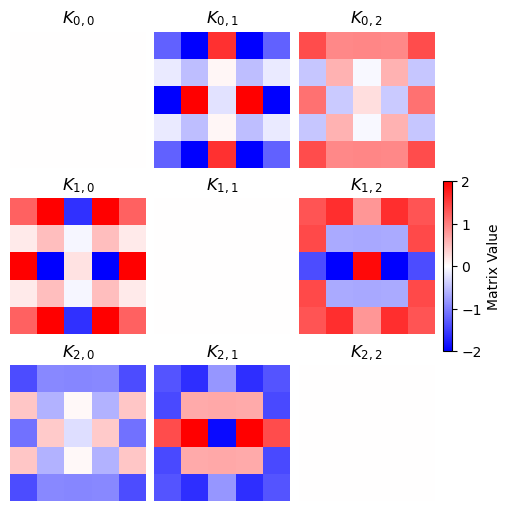

In [7]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

w = torch.randn(3,3, 5, 5)
w = (w + w.flip(-1)) / 1.414
w = (w + w.flip(-2)) / 1.414
w = (w + w.flip(-1)) / 1.414
w = (w + w.flip(-2)) / 1.414
k = (w - w.transpose(0,1).flip(-1, -2)) / 2

fig, axes = plt.subplots(k.shape[0], k.shape[1], figsize=(5,5), constrained_layout=True)
# norm = mpl.colors.Normalize(vmin=-3, vmax=3)
for o in range(k.shape[0]):
    for i in range(k.shape[1]):
        im = axes[o, i].imshow(k[o, i].cpu(), cmap='bwr', vmin=-2, vmax=2)
        axes[o, i].set_title(f'$K_{{{o},{i}}}$')
        axes[o, i].axis('off')

cbar = fig.colorbar(im, ax=axes, fraction=0.02, pad=0.02)
cbar.set_label('Matrix Value')
# plt.savefig('./figures/kernel.pdf', bbox_inches='tight')
plt.show()